In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/result2/kaggle/working/results1/checkpoint-4221/adapter_model.safetensors
/kaggle/input/result2/kaggle/working/results1/checkpoint-4221/trainer_state.json
/kaggle/input/result2/kaggle/working/results1/checkpoint-4221/training_args.bin
/kaggle/input/result2/kaggle/working/results1/checkpoint-4221/adapter_config.json
/kaggle/input/result2/kaggle/working/results1/checkpoint-4221/README.md
/kaggle/input/result2/kaggle/working/results1/checkpoint-4221/scheduler.pt
/kaggle/input/result2/kaggle/working/results1/checkpoint-4221/optimizer.pt
/kaggle/input/result2/kaggle/working/results1/checkpoint-4221/rng_state.pth
/kaggle/input/result2/kaggle/working/results1/checkpoint-2814/adapter_model.safetensors
/kaggle/input/result2/kaggle/working/results1/checkpoint-2814/trainer_state.json
/kaggle/input/result2/kaggle/working/results1/checkpoint-2814/training_args.bin
/kaggle/input/result2/kaggle/working/results1/checkpoint-2814/adapter_config.json
/kaggle/input/result2/kaggle/working/res

In [2]:
from datasets import load_dataset
import re

In [3]:

dataset=load_dataset("imdb")




In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
length=[len(x.split()) for x in dataset['train']['text']]

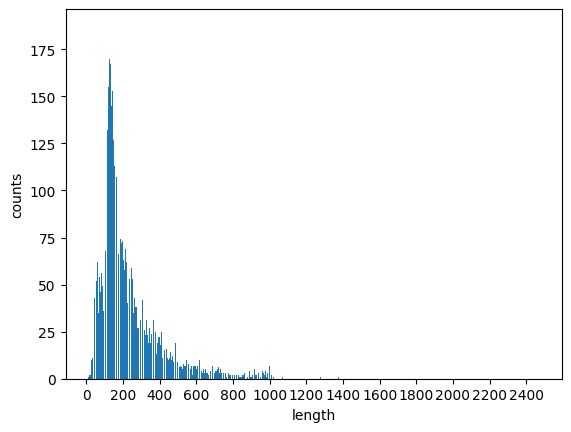

In [6]:
import collections
import matplotlib.pyplot as plt
from collections import Counter
count =Counter(length)

keys=list(count.keys())
values=list(count.values())
plt.bar(keys,values)
plt.xlabel("length")
plt.ylabel("counts")
plt.xticks(range(0,max(length),200))
plt.show()

In [7]:
def cleaned_text(text):
        text=re.sub(r'<.*?>',"",text)
        text=re.sub(r'[^a-zA-z\s]',"",text)
        text=text.lower()
        text=re.sub(r'\s+'," ",text).strip()
        return text



In [8]:
# train_data

In [9]:
# train_cleaned = [cleaned_text(text) for text in train_data['text']]

In [10]:
# train_cleaned[0]

In [11]:
from sklearn.model_selection import train_test_split

train_data=dataset["train"]
test_data=dataset["test"]
def create_validation_split(data,val_size=0.1,seed=42):
    train_idx,val_idx=train_test_split(range(len(data)),
                                    test_size=val_size,
                                    stratify=data['label'],
                                    random_state=seed
                                    )
    return train_idx,val_idx


In [12]:
train_idx,val_idx=create_validation_split(train_data)
train_data=train_data.select(train_idx)
validation_data=dataset['train'].select(val_idx)


In [13]:
import re
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from torch.utils.data import Dataset,DataLoader
tokenizer=AutoTokenizer.from_pretrained("bert-base-uncased")



class IMDPdataset(Dataset):
    def __init__(self,text,label,tokenizer):
        self.text=text
        self.label=label
        self.tokenizer=tokenizer
    def __len__(self):
        return len(self.text)

    @staticmethod
    def cleaned_text(text):
        text=re.sub(r'<.*?>',"",text)
        text=re.sub(r'[^a-zA-z\s]',"",text)
        text=text.lower()
        text=re.sub(r'\s+'," ",text).strip()
        return text
    
    def __getitem__(self,idx):
        cleaned=self.cleaned_text(self.text[idx])
        x=tokenizer(cleaned,
        padding="max_length",
        max_length=512,
        truncation=True,
        return_tensors="pt"
    )
        return{"input_ids":x['input_ids'].squeeze(0),
               "attention_mask":x['attention_mask'].squeeze(0),
               "label":self.label[idx]}
        
        

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
train_dataset=IMDPdataset(train_data['text'],train_data['label'],tokenizer)
test_dataset=IMDPdataset(test_data['text'],test_data['label'],tokenizer)
val_dataset=IMDPdataset(validation_data['text'],validation_data['label'],tokenizer)


In [15]:
for i in range(3):
    sample=next(iter(train_dataset))
    print(sample['input_ids'])
    print(sample['attention_mask'])
    print(sample['label'])


tensor([  101,  2632, 11239,  1996, 18594,  2003,  2028,  2919,  1998,  4895,
        11263, 10695,  2100,  4333,  4038,  1996, 10984,  1997,  1996, 14308,
        21354,  2003,  3294,  2125,  2023,  2003,  1996,  2785,  1997,  8562,
         2007,  3056, 10071,  2008,  2191,  2017,  4687,  2065,  2027,  2890,
         4011,  2000,  2022,  6057,  2030,  2025,  2174,  1996,  5025,  3737,
         1997,  1996,  2143,  2003, 22537,  2023,  2003, 10915, 10523,  2005,
         2143, 23176,  2015,  3701,  2138,  2049,  2028,  1997,  1996,  5700,
         4973,  1997,  5637,  5988,  1996,  2364,  2839,  1997,  2632, 11239,
         2003,  2019,  1041, 16020, 19269,  3124,  3772,  2172,  2066,  1996,
        12991, 27086,  6090,  6508,  2691,  1999,  2116,  2220,  3152,  1996,
         2143,  2038,  1996, 24004, 20200,  7729,  2691,  1997,  1996,  2051,
         2632, 11239,  1996, 18594,  2003,  3492,  9643,  2021, 17160,  2013,
         1037,  3439, 21386,   102,     0,     0,     0,     0, 

In [16]:
# !pip uninstall -y peft huggingface_hub

# # Install specific versions that work together
# !pip install huggingface_hub==0.16.4
# !pip install peft

In [17]:
from transformers import AutoModelForSequenceClassification

from peft import get_peft_model, LoraConfig, TaskType

In [18]:
model=AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_lin", "k_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

In [20]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [21]:
peftmodel=get_peft_model(model,lora_config)

In [22]:
!pip install wandb
import wandb

In [23]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")


wandb.login(key=secret_value_0)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: basem-yasser. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
from transformers import TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
num_training_steps = len(train_dataset) * 3 // 16  # (dataset_size * epochs) // batch_size
warmup_steps = num_training_steps // 10  # 10% of total steps


training_args = TrainingArguments(
    output_dir="./results1",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=warmup_steps,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",    
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="wandb",              
    run_name="imdb-sentiment-run1"   
)

# 2. Define metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 3. Initialize Trainer
trainer = Trainer(
    model=peftmodel,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    compute_metrics=compute_metrics,      
)

trainer.train(resume_from_checkpoint="/kaggle/input/result2/kaggle/working/results1/checkpoint-4221")
# eval_results = trainer.evaluate(test_dataset)
# print(eval_results)

# trainer.save_model("./final_model")

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Could not locate the best model at ./results1/checkpoint-4221/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=4221, training_loss=0.0, metrics={'train_runtime': 6.453, 'train_samples_per_second': 10460.325, 'train_steps_per_second': 654.119, 'total_flos': 9247792343040000.0, 'train_loss': 0.0, 'epoch': 3.0})

In [25]:
# !zip -r results1.zip /kaggle/working/results1

In [26]:
testdataloader=DataLoader(test_dataset,batch_size=16)

In [27]:
import torch
def predict_sentiment(text):
    inputs=tokenizer(text,
                     padding="max_length",
                     max_length=512,
                     truncation=True,
                     return_tensors="pt")
    
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']
        
    device="cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    
    inputs={k:v.to(device)for k,v in inputs.items()}
        
    output=model(**inputs)
    predictions=torch.nn.functional.softmax(output.logits,dim=-1)
    class_pred=torch.argmax(predictions,dim=-1).item()
    confidence=predictions[0][class_pred].item()
    return {
        "sentiment":"positive"if class_pred==1 else "negative",
        "confidence":f"{confidence:.2f}",
        "class_pred":{class_pred}
    }


    
                     

In [28]:
texts = [
    "This movie was amazing! I loved every minute of it.",
    "Terrible waste of time, wouldn't recommend.",
    "It was okay, not great but not bad either."
]
for text in texts:
    result=predict_sentiment(text)
    print(text)
    print(result["sentiment"])
    print(result["confidence"])



This movie was amazing! I loved every minute of it.
positive
1.00
Terrible waste of time, wouldn't recommend.
negative
0.93
It was okay, not great but not bad either.
positive
0.62


In [39]:
def predict_classesy(data):
    y_pred=[]
    device="cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    for batch in data:
        if 'token_type_ids' in batch:
            del batch['token_type_ids']
        if 'label' in batch:
            del batch['label']
        inputs={k:v.to(device)for k,v in batch.items()}
        output=model(**inputs)
        predictions=torch.nn.functional.softmax(output.logits,dim=-1)
        class_pred=torch.argmax(predictions,dim=-1)
        y_pred.append(class_pred)
    return y_pred
    

In [49]:
y_prediction=predict_classesy(testdataloader)

In [50]:
len(y_prediction)

1563

In [51]:

y_prediction_flaten=torch.cat(y_prediction,dim=0)
y_prediction_numpy=y_prediction_flaten.cpu().detach().numpy()

In [53]:
len(y_prediction_numpy)

25000

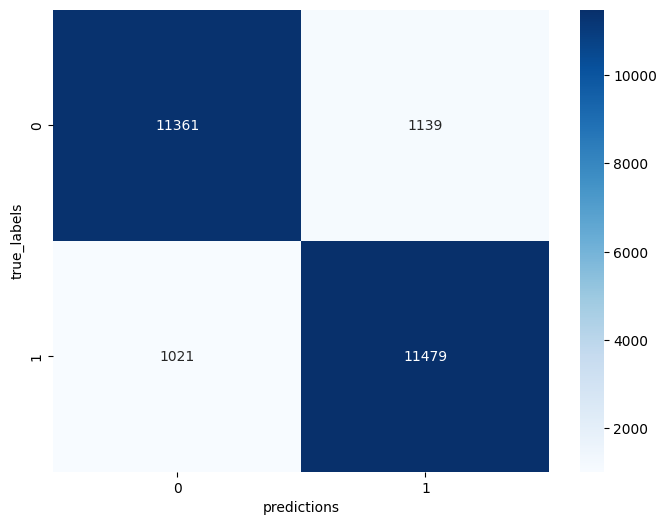

              precision    recall  f1-score   support

           0       0.92      0.91      0.91     12500
           1       0.91      0.92      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

Final Model Performance:
Total examples: 25000
Misclassified examples: 2160
Accuracy: 91.36%


In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true=test_data['label']
cm=confusion_matrix(y_true,y_prediction_numpy)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel("true_labels")
plt.xlabel("predictions")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_true, y_prediction_numpy))
print("Final Model Performance:")
print(f"Total examples: {len(y_true)}")
print(f"Misclassified examples: {len(misclassified_indices)}")
print(f"Accuracy: {(1 - len(misclassified_indices)/len(y_true))*100:.2f}%")

now let's check the missclassified examples 
****


In [73]:
misclassified_indices=np.where(y_true!=y_prediction_numpy)[0]
misclassified_indices
for idx in misclassified_indices:
    print(f"idx num: {idx}")
    print(f"true label is: {y_true[idx]}")
    print(f"predicted label is:  {y_prediction_numpy[idx]}")
    print(f"text is:  {test_data['text'][idx]}")
    print("-"*50)
    break
      

idx num: 4
true label is: 0
predicted label is:  1
text is:  First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!
--------------------------------------------------


In [69]:
from collections import Counter
import re

def get_common_words(texts):
    words = ' '.join(texts).lower()
    words = re.findall(r'\w+', words)
    return Counter(words).most_common(20)

common_error_words = get_common_words(error_distribution['text'])
print("Most common words in errors:", common_error_words)

Most common words in errors: [('the', 30228), ('a', 14752), ('and', 13967), ('of', 12964), ('to', 12021), ('br', 9410), ('is', 9001), ('in', 8551), ('it', 8388), ('i', 7191), ('that', 6613), ('s', 5948), ('this', 5936), ('was', 4127), ('for', 4028), ('as', 4018), ('but', 3948), ('with', 3942), ('movie', 3442), ('you', 3224)]
